# This is the analysis that has been used in the paper. 

* We do not refine the resistance layer according to eBird data. 
* We do use the terrain that has some general transmissivity for compatible terrain with forest birds. 

## Code Setup

In [13]:
# Path to main directory
LOCAL_PATH = "data/CA-Final"
DATA_PATH = LOCAL_PATH

In [14]:
import os
import pandas as pd
import numpy as np
import sys
from IPython.core.display import HTML



In [15]:
sys.path.append(os.path.join(os.getcwd(), "birdmaps"))
from birdmaps import bird_runs


## Bird Run Definition

In [16]:

bird_run = bird_runs.BirdRun(DATA_PATH)

birds = []

NUM_SIMULATIONS = 400
NUM_SPREADS = [2, 3, 4, 6, 8, 10, 15, 20, 30, 40]
HOPS = [1, 2, 3, 4, 5, 6]
RUN_NAME = "Paper"

for hop_distance in HOPS:
    for num_spreads in NUM_SPREADS:
        birds.append(bird_run.get_bird_run(
            "acowoo", "Acorn Woodpecker",
            do_validation=True, run_name=RUN_NAME,
            hop_distance=hop_distance, num_spreads=num_spreads,
            num_simulations=NUM_SIMULATIONS))

for hop_distance in HOPS:
    for num_spreads in NUM_SPREADS:
        birds.append(bird_run.get_bird_run(
            "stejay", "Steller's Jay",
            do_validation=True, run_name=RUN_NAME,
            hop_distance=hop_distance, num_spreads=num_spreads,
            num_simulations=NUM_SIMULATIONS))


For a given run, we can read a dataframe contains, for each square, the:
* Number of checklists
* Number of checklists containing the bird
* Total number of birds (of the given species) seen
* average habitat around the square (counting 1 as habitat and 0 as non-habitat)
* max habitat around the square
* average repopulation around the square (counting as 0 out of habitat of course)
* max repopulation around the square.

I look for the correlation between:
* Average number of birds seen (the BirdRatio),
* Max repopulation (MaxRepopRange).

Why max repopulation and not average?  Because average repopulation mixes two concerns: (a) how much habitat there is around, and (b) how high the repopulation is in that habitat.  This confounds the signal.  It is much cleaner to look at the correlation between BirdRatio and MaxRepopRange.

In [17]:
def wmean(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def wcov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - wmean(x, w)) * (y - wmean(y, w))) / np.sum(w)

def wcorr(x, y, w):
    """Weighted Correlation"""
    return wcov(x, y, w) / np.sqrt(wcov(x, x, w) * wcov(y, y, w))

In [18]:
# Here we get a bit of statistical data. 
one_run = bird_run.get_bird_run(
            "acowoo", "Acorn Woodpecker",
            do_validation=True, run_name=RUN_NAME,
            hop_distance=hop_distance, num_spreads=num_spreads,
            num_simulations=NUM_SIMULATIONS)
df = pd.read_csv(one_run.obs_csv_path)
print("Num checklists:", df["NumChecklists"].sum())
print("Num locations:", len(df))
print("Num locations with > 10 checklists", len(df.loc[lambda row : row["NumChecklists"] > 10]))
print("Num locations with > 100 checklists", len(df.loc[lambda row : row["NumChecklists"] > 100]))

Num checklists: 185996.0
Num locations: 18336
Num locations with > 10 checklists 3169
Num locations with > 100 checklists 296


In [19]:
import matplotlib.pyplot as plt
from matplotlib import cm
import colorcet
from scipy import stats
from sklearn.linear_model import LinearRegression

In [20]:

# Let's create a method to display the performance of a bird.


surfX, surfY = np.meshgrid(np.array(NUM_SPREADS, dtype=float), np.array(HOPS, dtype=float))

def plot_bird_correlation(bird_nickname, max_checklists=100):
    variation = np.zeros_like(surfX)
    corr_loc = np.zeros_like(surfX)
    r_square = np.zeros_like(surfX)
    for bird in birds:
        if bird.nickname == bird_nickname:
            bird_name = bird.name
            df = pd.read_csv(bird.obs_csv_path)
            df = df.loc[lambda r : r["max_hab"] > 0.9]
            num_locations_in_habitat = df["NumChecklists"].count()
            df["MaxRepopRange"] = df.apply(lambda row : int(row["max_repop"] * 9.999) / 10, axis=1)
            vals = list(df.groupby("MaxRepopRange")["BirdRatio"].indices.keys())
            spread_idx = NUM_SPREADS.index(bird.num_spreads)
            hop_idx = HOPS.index(bird.hop_distance)
            x = np.array(vals)
            # Now selects only location with a given number of checklists. 
            df = df.loc[lambda r: r["NumChecklists"] <= max_checklists]
            num_locations_considered = df["NumChecklists"].count()
            vals = list(df.groupby("MaxRepopRange")["BirdRatio"].indices.keys())
            tot_locations = df.groupby("MaxRepopRange")["NumChecklists"].count()
            ys_loc = df.groupby("MaxRepopRange")["BirdRatio"].mean()
            spread_idx = NUM_SPREADS.index(bird.num_spreads)
            hop_idx = HOPS.index(bird.hop_distance)
            x = np.array(vals)
            y_loc = np.array(ys_loc)
            w_loc = np.array(tot_locations)
            corr_loc[hop_idx, spread_idx] = wcorr(x, y_loc, w_loc)
            # Computes the explained variation.
            reg = LinearRegression().fit(x.reshape(-1, 1), y_loc.reshape(-1, 1), w_loc)
            intercept = reg.predict(np.array([[0]]))
            highp = reg.predict(np.array([[0.9]]))
            # slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y_loc)
            # highp = intercept + slope
            lowp = max(0, intercept)
            variation[hop_idx, spread_idx] = (highp - lowp) / highp
            r_square[hop_idx, spread_idx] = reg.score(x.reshape(-1, 1), y_loc.reshape(-1, 1), w_loc)

            
    def format_yticks(tick_val, tick_pos):
        return "{:.1f}".format(tick_val * 0.3)

    display(HTML("<h2>{} Correlation</h2>".format(bird_name)))
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(surfX, surfY, corr_loc, cmap=colorcet.cm.rainbow_bgyr_10_90_c83, clim=(0, 1), linewidth=1)
    ax.set_zlim((-0.1, 1.1))
    ax.set_xticks(NUM_SPREADS)
    ax.set_yticks(HOPS)
    ax.yaxis.set_major_formatter(format_yticks)
    ax.set_xlabel("N. crossings")
    ax.set_ylabel("Gap crossing, Km")
    fig.colorbar(surf, shrink=0.5, aspect=10)
    # plt.title("{} Correlation".format(bird_name))
    plt.show()
    fig.savefig("Figures/Correlation {}.pdf".format(bird_name), bbox_inches="tight", format="pdf")
    
    display(HTML("<h2>{} Explained variation</h2>".format(bird_name)))
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surfv = ax.plot_surface(surfX, surfY, variation, cmap=colorcet.cm.rainbow_bgyr_10_90_c83, clim=(0., 1.), linewidth=1)
    # ax.view_init(elev=30, azim=-45)
    ax.set_xticks(NUM_SPREADS)
    ax.set_yticks(HOPS)
    ax.set_zlim((-0.1, 1.1))
    ax.yaxis.set_major_formatter(format_yticks)
    ax.set_xlabel("N. crossings")
    ax.set_ylabel("Gap crossing, Km")
    fig.colorbar(surfv, shrink=0.5, aspect=10)
    # plt.title("{} Explained Variation".format(bird_name))
    plt.show()
    fig.savefig("Figures/Explained Variation {}.pdf".format(bird_name), bbox_inches="tight", format="pdf")

    display(HTML("<h2>{} Coefficient of determination</h2>".format(bird_name)))
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surfv = ax.plot_surface(surfX, surfY, r_square, cmap=colorcet.cm.rainbow_bgyr_10_90_c83, clim=(0., 1.), linewidth=1)
    # ax.view_init(elev=30, azim=-45)
    ax.set_zlim((-0.1, 1.1))
    ax.set_xticks(NUM_SPREADS)
    ax.set_yticks(HOPS)
    ax.yaxis.set_major_formatter(format_yticks)
    ax.set_xlabel("N. crossings")
    ax.set_ylabel("Gap crossing, Km")
    fig.colorbar(surfv, shrink=0.5, aspect=10)
    # plt.title("{} Coefficient of determination".format(bird_name))
    plt.show()
    fig.savefig("Figures/Coefficient of determination {}.pdf".format(bird_name), bbox_inches="tight", format="pdf")

    print("Location Correlation, max checklists = {}:".format(max_checklists))
    display(pd.DataFrame(corr_loc, index=HOPS, columns=NUM_SPREADS))
    
    print("Explained variation, max checklists = {}:".format(max_checklists))
    display(pd.DataFrame(variation, index=HOPS, columns=NUM_SPREADS))
    
    print("Coefficient of determination:")
    display(pd.DataFrame(r_square, index=HOPS, columns=NUM_SPREADS))

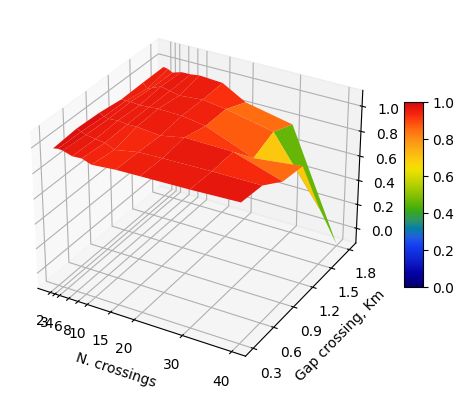

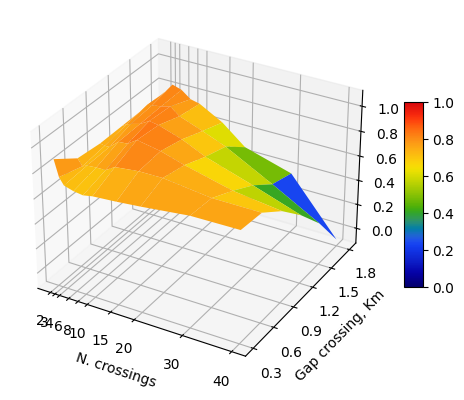

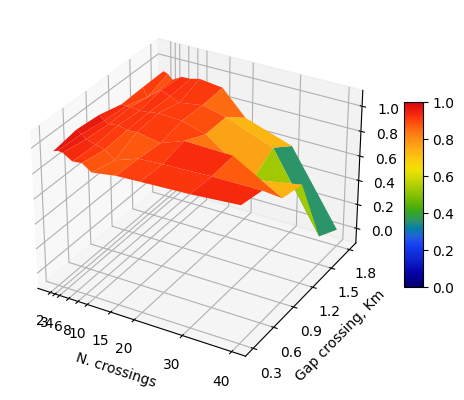

Location Correlation, max checklists = 100:


,2,3,4,6,8,10,15,20,30,40
1,0.977039,0.984353,0.981690,0.958391,0.962503,0.935815,0.951125,0.955610,0.963891,0.978694
2,0.993414,0.980203,0.965434,0.953744,0.944985,0.911079,0.946054,0.951987,0.958985,0.959763
3,0.983839,0.964696,0.956388,0.962286,0.953373,0.955364,0.936863,0.973667,0.967907,0.845916
4,0.958733,0.956186,0.958304,0.952768,0.957154,0.963458,0.958479,0.928836,0.779216,0.822619
5,0.962582,0.926035,0.940713,0.970600,0.955826,0.938461,0.954145,0.928898,0.850210,0.328797
6,0.963988,0.957976,0.937129,0.960116,0.961824,0.971655,0.959527,0.851819,0.773237,-0.108707


Explained variation, max checklists = 100:


,2,3,4,6,8,10,15,20,30,40
1,0.893291,0.763770,0.708715,0.686455,0.675731,0.690266,0.704025,0.722082,0.764955,0.770328
2,0.759669,0.707158,0.723394,0.729406,0.730782,0.775984,0.797391,0.798656,0.752838,0.752089
3,0.739600,0.731402,0.732051,0.794212,0.800373,0.850329,0.815001,0.757461,0.664012,0.615039
4,0.743570,0.767825,0.781270,0.801625,0.845379,0.832730,0.770410,0.683590,0.561835,0.432239
5,0.747461,0.795001,0.799264,0.810648,0.830227,0.771064,0.701525,0.626429,0.426372,0.215355
6,0.752199,0.785228,0.838992,0.815179,0.758023,0.740252,0.636464,0.483211,0.371706,-0.072150


Coefficient of determination:


,2,3,4,6,8,10,15,20,30,40
1,0.954606,0.968951,0.963715,0.918513,0.926411,0.875750,0.904639,0.913190,0.929085,0.957841
2,0.986870,0.960798,0.932063,0.909628,0.892996,0.830064,0.895019,0.906280,0.919652,0.921145
3,0.967939,0.930637,0.914678,0.925995,0.908921,0.912720,0.877712,0.948028,0.936843,0.715573
4,0.919169,0.914291,0.918347,0.907768,0.916144,0.928251,0.918682,0.862736,0.607178,0.676702
5,0.926564,0.857540,0.884942,0.942065,0.913604,0.880708,0.910393,0.862852,0.722857,0.108108
6,0.929272,0.917719,0.878212,0.921823,0.925106,0.944114,0.920691,0.725596,0.597895,0.011817


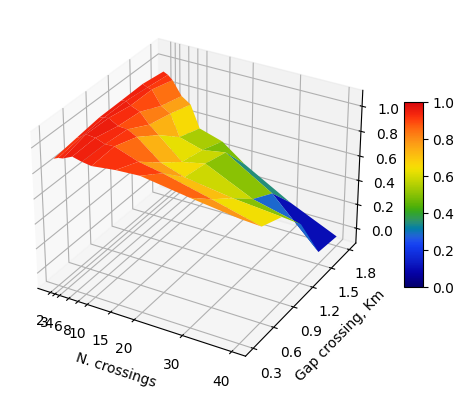

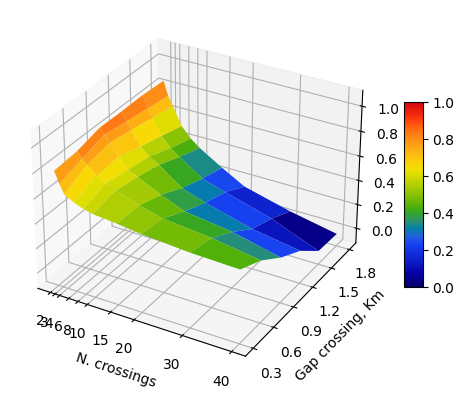

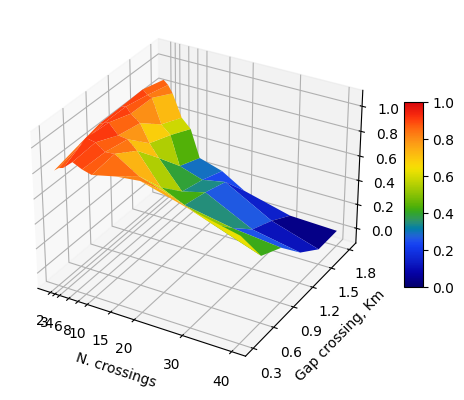

Location Correlation, max checklists = 100:


,2,3,4,6,8,10,15,20,30,40
1,0.896562,0.913409,0.919910,0.955397,0.936789,0.925560,0.948450,0.959031,0.901748,0.852309
2,0.922908,0.940948,0.970266,0.962940,0.934367,0.937736,0.871571,0.836026,0.743644,0.644747
3,0.947460,0.955971,0.962560,0.919615,0.913862,0.874470,0.724508,0.661554,0.605123,0.569324
4,0.949968,0.954712,0.929442,0.898974,0.816247,0.752718,0.588245,0.628049,0.450584,0.359347
5,0.953601,0.934667,0.927199,0.814663,0.771896,0.600115,0.546150,0.578682,0.350734,-0.022348
6,0.926914,0.908925,0.875911,0.764581,0.714304,0.535859,0.478667,0.339164,0.126666,-0.045583


Explained variation, max checklists = 100:


,2,3,4,6,8,10,15,20,30,40
1,0.802758,0.711586,0.638903,0.596333,0.568386,0.550257,0.531662,0.508124,0.478653,0.466580
2,0.818340,0.768225,0.728318,0.666124,0.627690,0.589416,0.526994,0.479677,0.438737,0.379359
3,0.865489,0.820304,0.763144,0.676946,0.591854,0.554683,0.465090,0.386627,0.334875,0.245428
4,0.862415,0.791136,0.731516,0.618771,0.559042,0.510031,0.374194,0.309453,0.206591,0.143517
5,0.864622,0.763311,0.695053,0.568206,0.487185,0.434786,0.308503,0.250107,0.140800,-0.013400
6,0.851438,0.736521,0.662500,0.514345,0.430559,0.372349,0.257167,0.151576,0.052596,-0.023901


Coefficient of determination:


,2,3,4,6,8,10,15,20,30,40
1,0.803823,0.834316,0.846234,0.912783,0.877573,0.856662,0.899557,0.919740,0.813149,0.726431
2,0.851759,0.885384,0.941415,0.927252,0.873042,0.879349,0.759637,0.698939,0.553007,0.415698
3,0.897681,0.913881,0.926521,0.845692,0.835144,0.764699,0.524912,0.437654,0.366174,0.324130
4,0.902439,0.911474,0.863863,0.808155,0.666260,0.566584,0.346032,0.394446,0.203026,0.129130
5,0.909354,0.873602,0.859699,0.663677,0.595823,0.360138,0.298280,0.334873,0.123014,0.000499
6,0.859170,0.826145,0.767220,0.584583,0.510230,0.287145,0.229122,0.115032,0.016044,0.002078


In [21]:
for bird in ["acowoo", "stejay"]:
    plot_bird_correlation(bird)